# 1. Install Dependencies and Setup

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout, ReLU, MaxPool2D, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
import cv2

import os
from tqdm.notebook import tqdm
tqdm.pandas()

import cv2
import imghdr
from struct import unpack

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [4]:
data_dir = '../Dataset/Datasets/' 

In [5]:
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break   

bads = []
for image_class in tqdm(os.listdir(data_dir)): 
    for image in tqdm(os.listdir(os.path.join(data_dir, image_class))):
        image_path = os.path.join(data_dir, image_class, image)
        image = JPEG(image_path) 
        try:
            image.decode()   
        except:
            bads.append(image_path)  

print(len(bads))

# for name in bads:
#     os.remove(os.path.join(name))


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0


In [6]:
image_exts = ['jpeg','jpg', 'png']


for image_class in tqdm(os.listdir(data_dir)): 
# for image_class in os.listdir(data_dir): 
    print(image_class)
    for image in tqdm(os.listdir(os.path.join(data_dir, image_class))):
    # for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)

        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)

        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

  0%|          | 0/5 [00:00<?, ?it/s]

Bacteria


  0%|          | 0/50 [00:00<?, ?it/s]

Fungi


  0%|          | 0/50 [00:00<?, ?it/s]

Nematodes


  0%|          | 0/49 [00:00<?, ?it/s]

Normal


  0%|          | 0/40 [00:00<?, ?it/s]

Virus


  0%|          | 0/50 [00:00<?, ?it/s]

# 3. Load Data

In [10]:
data = image_dataset_from_directory('../Dataset/Datasets/', batch_size = 8, label_mode='categorical', image_size=(112,112))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 239 files belonging to 5 classes.


c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


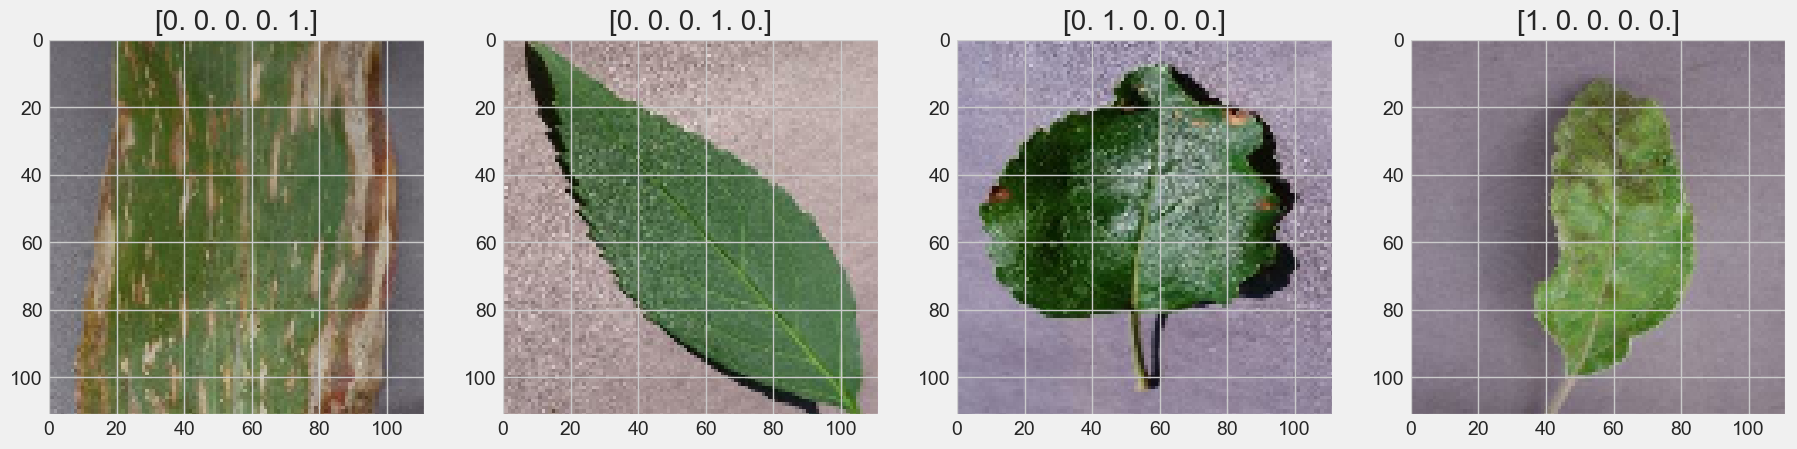

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [12]:
data = data.map(lambda x,y: (x/255, y))

# 5. Split Data

In [13]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

print(train_size)
print(val_size)
print(test_size)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

21
6
3


# 6. Build Deep Learning Model

In [28]:
vgg16 = VGG16(include_top= False, weights= "imagenet", input_shape= (112,112,3), pooling= 'max')

In [33]:
model = Sequential()
# model.add(Conv2D(input_shape=(112,112,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# # model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# # model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# # model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Flatten())
model.add(vgg16)
model.add(BatchNormalization())
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=64,activation="relu"))

model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate = 0.000_01)

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 5)                 325       
                                                                 
Total params: 14,790,981
Trainable params: 14,789,957
Non-trainable params: 1,024
______________________________________

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(224,224,3)))
model.add(Conv2D(filters=16,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.9))
model.add(BatchNormalization())

model.add(Conv2D(filters=32,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())


model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())

model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())

# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.75))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1000, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate = 0.001)

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
# model = Sequential()

# model.add(Conv2D(128, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same',  input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(64, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(64, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# # model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# # model.add(MaxPooling2D())
# # model.add(Dropout(0.4))
# # model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# # model.add(Dense(256, activation='relu'))
# # model.add(Dropout(0.2))

# model.add(Dense(4, activation='softmax'))

# opt = Adam(learning_rate = 0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy()

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(112,112,3)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.8))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate = 0.0001)

model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# 7. Train

In [34]:
epoch = 10

hist = model.fit(train, epochs=epoch, validation_data=val)

Epoch 1/10
21/21 [==============================] - 3s 109ms/step - loss: 1.3692 - accuracy: 0.4464 - val_loss: 1.7984 - val_accuracy: 0.4375
Epoch 2/10
21/21 [==============================] - 2s 102ms/step - loss: 1.0098 - accuracy: 0.6726 - val_loss: 1.7057 - val_accuracy: 0.3542
Epoch 3/10
21/21 [==============================] - 2s 103ms/step - loss: 0.8570 - accuracy: 0.8155 - val_loss: 1.5257 - val_accuracy: 0.4792
Epoch 4/10
21/21 [==============================] - 2s 102ms/step - loss: 0.7398 - accuracy: 0.8631 - val_loss: 1.2850 - val_accuracy: 0.4792
Epoch 5/10
21/21 [==============================] - 2s 102ms/step - loss: 0.6179 - accuracy: 0.9286 - val_loss: 1.0193 - val_accuracy: 0.5833
Epoch 6/10
21/21 [==============================] - 2s 102ms/step - loss: 0.5266 - accuracy: 0.9821 - val_loss: 0.8357 - val_accuracy: 0.6875
Epoch 7/10
21/21 [==============================] - 2s 103ms/step - loss: 0.4475 - accuracy: 0.9702 - val_loss: 0.7795 - val_accuracy: 0.6875
Epoch 

# 8. Plot Performance

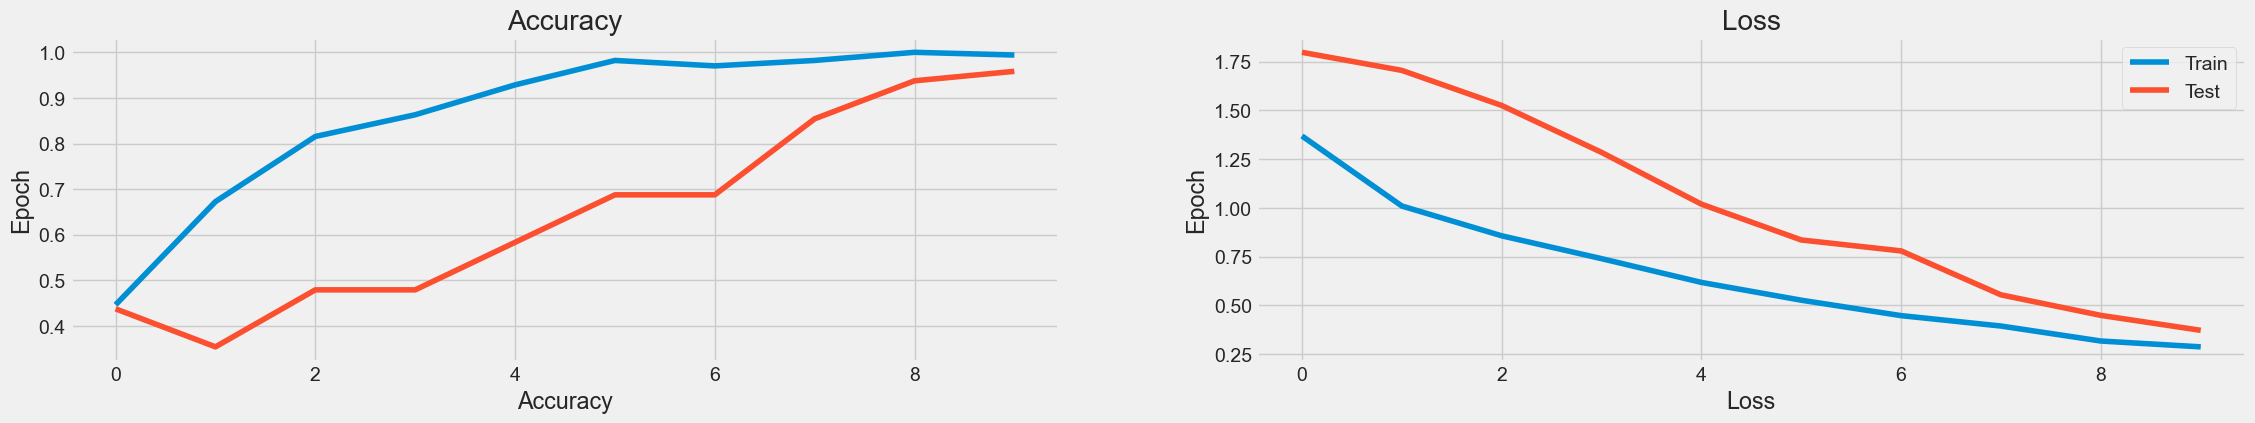

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

# 9. Evaluate

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f"Precision : {(pre.result().numpy())}")
print(f"Recall : {re.result().numpy()}")
print(f"Binary Accuracy : {acc.result().numpy()}")


Precision : 0.9473684430122375
Recall : 0.782608687877655
Binary Accuracy : 0.947826087474823


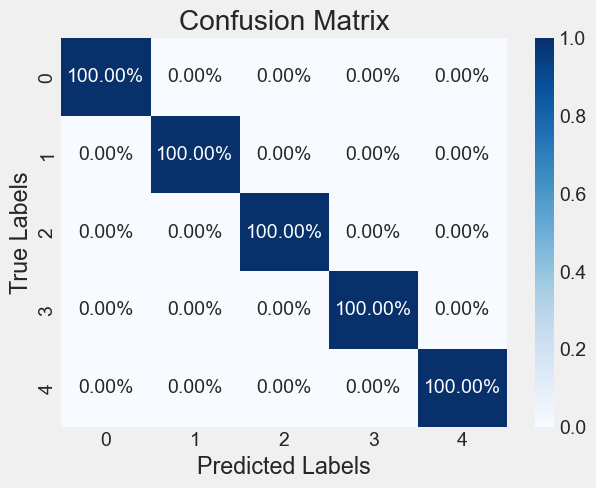

In [41]:
labels = []

label_pred,label_true = [], []
for batch in test.as_numpy_iterator(): 
    X, Y = batch
    pred = model.predict(X, verbose=0)
    label_pred.append(pred.argmax(axis=1))
    label_true.append(Y.argmax(axis=1))

label_true = np.concatenate(label_true).tolist()
label_pred = np.concatenate(label_pred).tolist()

con_mat = confusion_matrix(label_true, label_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 10. Test

In [ ]:
img_load = cv2.imread('TestImages/2021-08-18_12-42-27_UTC_2.jpg')
img = cv2.cvtColor(img_load, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
pred = yhat.argmax()

# 11. Save the Model

In [37]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('models/imageclassifier.h5')
pred_model = new_model.predict(np.expand_dims(resize/255, 0))
label = pred_model.argmax()